In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cell_types = """“VIP” “SNCG” “LAMP5” “SST”  “PVALB” “ChC” “L2_3_IT” “L4_5_IT”    “L5_IT” “L6_IT” “L6_IT_CAR3”  “L5_ET” “L5_6_NP”    “L6_CT” “L6b”  “Endo” “VLMC” “MGC”  “OPC”  “ODC”  “ASC”"""
cell_types = cell_types.split('”')
cell_types = [i.strip(' “') for i in cell_types]
cell_types = cell_types[:-1]

In [3]:
cell_types

['VIP',
 'SNCG',
 'LAMP5',
 'SST',
 'PVALB',
 'ChC',
 'L2_3_IT',
 'L4_5_IT',
 'L5_IT',
 'L6_IT',
 'L6_IT_CAR3',
 'L5_ET',
 'L5_6_NP',
 'L6_CT',
 'L6b',
 'Endo',
 'VLMC',
 'MGC',
 'OPC',
 'ODC',
 'ASC']

In [4]:
gex_df_h = pd.read_csv('../../data/processed/gex_for_gls/log2cpm/{}_clusters_orthologous_counts.txt'.format('human'),
                                                            sep = '\t').set_index('human_gene')[cell_types]

In [5]:
gex_df_m= pd.read_csv('../../data/processed/gex_for_gls/log2cpm/{}_clusters_orthologous_counts.txt'.format('macaque'),
                                                            sep = '\t').set_index('human_gene')[cell_types]

In [6]:
from statsmodels.api import GLS
from numpy import cov
from scipy.stats import spearmanr

In [7]:
cov_use = (cov(gex_df_h.values.T) + cov(gex_df_m.values.T))/2

In [8]:
# cov_use = cov(gex_df_h.values.T)

In [9]:
from seaborn import heatmap

In [10]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [11]:
colors = """ASC	#6FF17D
ChC	#004EE3
Endo	#60C200
L2/3 IT	#FF6FEB
L4/5 IT	#F15A98
L5 ET	#EE7E94
L5 IT	#FA9E8B
L5/6 NP	#F24799
L6 CT	#EB9863
L6 IT	#EAACD3
L6 IT CAR3	#FF7F00
L6b	#FFAC3B
LAMP5	#3E9DDF
MGC	#70AD47
ODC	#ACF068
OPC	#C3D740
PVALB	#87B9DD
SNCG	#6167E1
SST	#684CE3
VIP	#9000E3
VLMC	#9CBC00"""
colors = colors.split('\n')
colors = [i.replace(' ', '_').replace('/', '_') for i in colors]
colors = {i.split('\t')[0]: i.split('\t')[1] for i in colors}

In [12]:
ordered_colors= [colors[i] for i in cell_types]

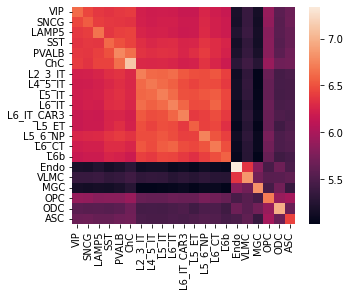

In [13]:
fig, ax = plt.subplots(figsize=(5,4))
im = heatmap(cov_use, ax=ax, xticklabels=cell_types, yticklabels=cell_types)

In [14]:
cov_use_2 = np.hstack([(np.arange(len(cell_types)) + .5).reshape(-1, 1), cov_use] )
cov_use_2 = np.vstack([(np.arange(-1, len(cell_types)) + .5).reshape(1, -1), cov_use_2])

In [15]:
# np.ma.masked_where(

In [16]:
from matplotlib import colors as cl

In [17]:
cell_cmap = cl.ListedColormap(ordered_colors)
bounds=np.arange(len(colors) +1)
norm = cl.BoundaryNorm(bounds, cell_cmap.N)

In [18]:
clust_mask = np.zeros(cov_use_2.shape)
clust_mask[:, 0] = 1
clust_mask[0, :] = 1
# clust_mask[0, 0] = 0
clust_mask2 = ~clust_mask.astype(bool)
clust_mask2[0, 0] = False

In [19]:
check = np.ma.masked_where(clust_mask, cov_use_2)

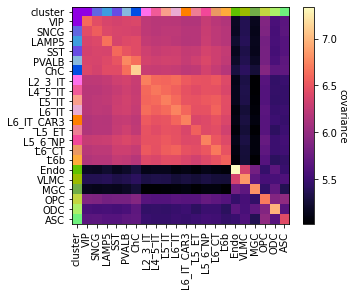

In [20]:
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(np.ma.masked_where(clust_mask, cov_use_2), cmap='magma')
cbar = plt.colorbar(im)
cbar.set_label('covariance',
                       rotation=270,
                       labelpad=10)
# xticklabels=['cluster'] + cell_types, yticklabels=cell_types
ax.imshow(np.ma.masked_where(clust_mask2, cov_use_2), cmap=cell_cmap, norm=norm)
ax.set_xticks(np.arange(22), labels=['cluster'] + cell_types, rotation=90)
ax.set_yticks(np.arange(22), labels=['cluster'] + cell_types,)
plt.savefig('../../figures/gls_covariance_matrix.pdf', dpi=400, bbox_inches='tight')

In [21]:
precision = np.linalg.inv(cov_use)

In [22]:
a = gex_df_h.loc['NOS1'].values

In [23]:
b = gex_df_m.loc['NOS1'].values

In [24]:
from statsmodels.api import OLS

In [25]:
order = np.argsort(a)

In [26]:
x =a[order]
y =b[order]

In [27]:
reg = OLS(x, y, hasconst=False)
res = reg.fit()

In [28]:
res.t_test([1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9626      0.096     10.051      0.000       0.763       1.162

In [29]:
import statsmodels

In [30]:
reg = OLS(x, y)
res = reg.fit()

In [31]:
reg = GLS(x, y, cov_use, hasconst=False)
res_g = reg.fit()

In [32]:
res_g.t_test([1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.3276      0.133      2.455      0.023       0.049       0.606

$$\hat{\beta} = (X^TX)^{-1}X^Ty$$
$$\hat{\beta} = (X^T\Sigma^{-1}X)^{-1}X^T\Sigma^{-1}y$$

In [33]:
res_g.bse

array([0.13346092])

In [34]:
res.bse

array([0.09577772])

In [35]:
t_stat = 22.822 
std_er = 0.045

In [36]:
pred_var = np.var(y -res.predict(x))

In [37]:
t_interval = 2.085963

In [38]:
from seaborn import regplot

In [39]:
grid = np.linspace(x.min(), x.max())

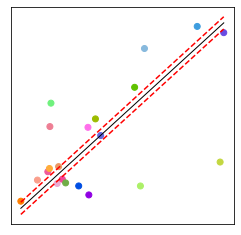

In [40]:
# st, data, ss2 = summary_table(res, alpha=0.05)
# summary = pd.read_html(st.as_html(), header=0, index_col=0)[0]
# summary = summary.dropna()
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(x, y, c=np.array(ordered_colors)[order])
ax.plot(x, res.predict(x), '-', lw=1, c='black')
ax.plot(x, res.predict(x)  + t_interval * res.bse, '--', c='red', label='regression uncertainty')
ax.plot(x, res.predict(x) - t_interval * res.bse, '--', c='red')
# ax.plot(x, iv_l, '--', c='red', label='regression uncertainty')
# ax.plot(x, iv_u, '--', c='red')
# ax.legend()

# ax.plot(x, res_g.predict(x)+1, '-', lw=1, c='black')
# ax.plot(x, res_g.predict(x) + t_interval * res_g.bse+1,  '--', c='red', label='95% ci' )
# ax.plot(x, res_g.predict(x) - t_interval * res_g.bse+1, '--', c='red')
# ax.show()
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('../../figures/uncorrected_gls_RYR3.pdf', dpi=400, bbox_inches='tight')

In [41]:
pred_var = np.var(y -res_g.predict(x))

Text(0.5, 1.0, 'nos1_human_x_macaque_y')

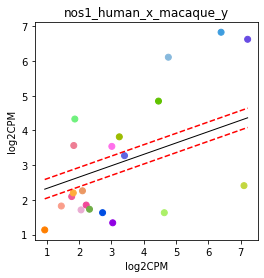

In [47]:
# st, data, ss2 = summary_table(res, alpha=0.05)
# summary = pd.read_html(st.as_html(), header=0, index_col=0)[0]
# summary = summary.dropna()
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(x, y, c=np.array(ordered_colors)[order])
# ax.plot(x, res.predict(x), '-', lw=1, c='black')
# ax.plot(x, res.predict(x) + t_interval * res.bse, '--', c='red')
# ax.plot(x, res.predict(x) - t_interval * res.bse, '--', c='red')


ax.plot(x, res_g.predict(x) + 2, '-', lw=1, c='black')
ax.plot(x, res_g.predict(x) + t_interval * res_g.bse+2,  '--', c='red', label='error of prediction' )
ax.plot(x, res_g.predict(x) - t_interval * res_g.bse+2, '--', c='red')
# ax.show()
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xlabel('log2CPM')
ax.set_ylabel('log2CPM')
plt.title('nos1_human_x_macaque_y')
# plt.savefig('../../figures/corrected_gls_RYR3.pdf', dpi=400, bbox_inches='tight')

In [45]:
a = gex_df_h.loc['NIPBL'].values

In [46]:
b = gex_df_m.loc['NIPBL'].values

In [47]:
order = np.argsort(a)

In [48]:
x =a[order]
y =b[order]

In [49]:
reg = OLS(x, y, hasconst=True)
res = reg.fit()

In [50]:
reg = GLS(x, y, cov_use, hasconst=True)
res_g = reg.fit()

In [51]:
res.t_test([1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9400      0.008    116.781      0.000       0.923       0.957

In [52]:
res_g.t_test([1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9756      0.063     15.460      0.000       0.844       1.107

In [115]:
0.8945/0.072

12.42361111111111

In [116]:
res.bse

array([0.00804943])

In [117]:
res_g.bse

array([0.06310409])

In [118]:
t_stat = res.t_test([1]).tvalue[0][0]
std_er = res.bse

In [119]:
pred_var = np.var(y -(res.predict(x)))

In [120]:
y-(res.predict(x))

array([1.34545015, 1.34027387, 1.24961276, 1.23494835, 1.22340353,
       1.09236191, 0.99650678, 1.18633284, 1.04450107, 1.09962409,
       1.0830559 , 1.17175552, 1.05409352, 0.98244993, 1.02079264,
       0.8051047 , 0.60768133, 0.85240995, 0.65477324, 0.61151642,
       0.38416713])

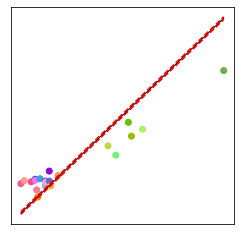

In [121]:
# st, data, ss2 = summary_table(res, alpha=0.05)
# summary = pd.read_html(st.as_html(), header=0, index_col=0)[0]
# summary = summary.dropna()
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(x, y, c=np.array(ordered_colors)[order])
ax.plot(x, res.predict(x)+1 , '-', lw=1, c='black')
ax.plot(x, res.predict(x) + t_interval * res.bse +1, '--', c='red', label='error of prediction' )
ax.plot(x, res.predict(x) - t_interval * res.bse +1, '--', c='red')

# ax.plot(x, res_g.predict(x) +1.2, '-', lw=1, c='black')
# ax.plot(x, res_g.predict(x) + t_interval * res_g.bse+1.2, '--', c='red', label='error of prediction' )
# ax.plot(x, res_g.predict(x) - t_interval * res_g.bse+1.2, '--', c='red')
# ax.show()
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('../../figures/uncorrected_gls_nipbl.pdf', dpi=400, bbox_inches='tight')

In [122]:
pred_var = np.var(y -(res_g.predict(x)))

In [123]:
pred_var = np.var(y -(res_g.predict(x)))

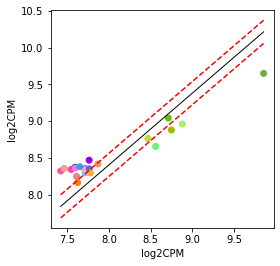

In [126]:
# st, data, ss2 = summary_table(res, alpha=0.05)
# summary = pd.read_html(st.as_html(), header=0, index_col=0)[0]
# summary = summary.dropna()
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(x, y, c=np.array(ordered_colors)[order])
# ax.plot(x, res.predict(x) +1, '-', lw=1, c='black')
# ax.plot(x, res.predict(x) + t_interval * res.bse+1, '--', c='red', label='error of prediction' )
# ax.plot(x, res.predict(x) - t_interval * res.bse+1, '--', c='red')

ax.plot(x, res_g.predict(x)+.6, 
         '-', lw=1, c='black')
ax.plot(x, res_g.predict(x) + t_interval * pred_var+.6, '--', c='red', label='error of prediction' )
ax.plot(x, res_g.predict(x) - t_interval * pred_var+.6, '--', c='red')
# ax.show()
ax.set_xlabel('log2CPM')
ax.set_ylabel('log2CPM')
# ax.set_xticks([])
# ax.set_yticks([])
plt.savefig('../../figures/corrected_gls_nipbl.pdf', dpi=400, bbox_inches='tight')

In [125]:
a = gex_df_h.loc['RIN3'].values

In [89]:
b = gex_df_m.loc['RIN3'].values

In [90]:
order = np.argsort(a)

In [91]:
x =a[order]
y =b[order]

In [92]:
reg = OLS(x, y, hasconst=True)
res = reg.fit()

In [93]:
reg = GLS(x, y, cov_use, hasconst=True)
res_g = reg.fit()

In [94]:
res.t_test([1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0264      0.077     13.349      0.000       0.866       1.187

In [95]:
res_g.t_test([1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.4044      0.152      2.653      0.015       0.086       0.722

In [96]:
0.8945/0.072

12.42361111111111

In [97]:
res.bse

array([0.07689467])

In [98]:
res_g.bse

array([0.15244568])

In [99]:
t_stat = res.t_test([1]).tvalue[0][0]
std_er = res.bse

In [100]:
pred_var = np.var(y -(res.predict(x)))

In [101]:
y-(res.predict(x))

array([ 5.62876209e-01,  5.87962705e-01,  2.96534353e-01,  1.68254997e+00,
       -2.75211306e-01,  1.43652061e+00, -7.41119377e-01,  3.59826077e-04,
       -7.00364151e-02, -4.37358448e-01,  2.09149297e+00, -2.83582133e-01,
       -8.64974718e-02, -1.25904901e+00, -2.21104591e+00, -5.17230350e-01,
       -6.93900203e-01, -1.60600433e+00,  8.83732119e-01, -1.66163872e+00,
       -2.66442105e+00])

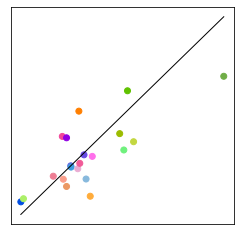

In [106]:
# st, data, ss2 = summary_table(res, alpha=0.05)
# summary = pd.read_html(st.as_html(), header=0, index_col=0)[0]
# summary = summary.dropna()
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(x, y, c=np.array(ordered_colors)[order])
ax.plot(x, res.predict(x) , '-', lw=1, c='black')
# ax.plot(x, res.predict(x) + t_interval * res.bse , '--', c='red', label='error of prediction' )
# ax.plot(x, res.predict(x) - t_interval * res.bse, '--', c='red')

# ax.plot(x, res_g.predict(x) +.2, '-', lw=1, c='black')
# ax.plot(x, res_g.predict(x) + t_interval * res_g.bse+1.2, '--', c='red', label='error of prediction' )
# ax.plot(x, res_g.predict(x) - t_interval * res_g.bse+1.2, '--', c='red')
# ax.show()
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('../../figures/uncorrected_gls_nipbl.pdf', dpi=400, bbox_inches='tight')

In [103]:
pred_var = np.var(y -(res_g.predict(x)))

In [104]:
pred_var = np.var(y -(res_g.predict(x)))

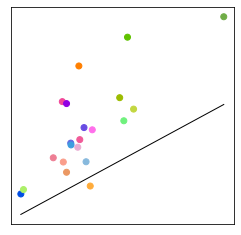

In [105]:
# st, data, ss2 = summary_table(res, alpha=0.05)
# summary = pd.read_html(st.as_html(), header=0, index_col=0)[0]
# summary = summary.dropna()
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(x, y, c=np.array(ordered_colors)[order])
# ax.plot(x, res.predict(x) +1, '-', lw=1, c='black')
# ax.plot(x, res.predict(x) + t_interval * res.bse+1, '--', c='red', label='error of prediction' )
# ax.plot(x, res.predict(x) - t_interval * res.bse+1, '--', c='red')

ax.plot(x, res_g.predict(x) +.2, '-', lw=1, c='black')
# ax.plot(x, res_g.predict(x) + t_interval * pred_var +1.2, '--', c='red', label='error of prediction' )
# ax.plot(x, res_g.predict(x) - t_interval * pred_var +1.2, '--', c='red')
# ax.show()
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('../../figures/corrected_gls_nipbl.pdf', dpi=400, bbox_inches='tight')

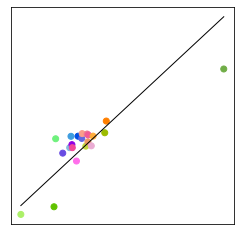

In [103]:
# st, data, ss2 = summary_table(res, alpha=0.05)
# summary = pd.read_html(st.as_html(), header=0, index_col=0)[0]
# summary = summary.dropna()
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(x, y, c=np.array(ordered_colors)[order])
# ax.plot(x, res.predict(x) +1, '-', lw=1, c='black')
# ax.plot(x, res.predict(x) + t_interval * res.bse+1, '--', c='red', label='error of prediction' )
# ax.plot(x, res.predict(x) - t_interval * res.bse+1, '--', c='red')

ax.plot(x, res_g.predict(x) +.2, '-', lw=1, c='black')
# ax.plot(x, res_g.predict(x) + t_interval * pred_var +1.2, '--', c='red', label='error of prediction' )
# ax.plot(x, res_g.predict(x) - t_interval * pred_var +1.2, '--', c='red')
# ax.show()
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('../../figures/corrected_gls_nipbl.pdf', dpi=400, bbox_inches='tight')

[]

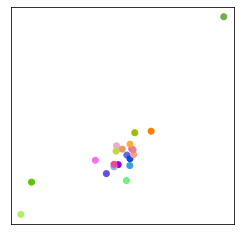

In [101]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.scatter(b, a, c=ordered_colors)
ax.set_yticks([])
ax.set_xticks([])
# plt.savefig('../../figures/uncorrected_gls_expression.pdf', dpi=400, bbox_inches='tight')

In [127]:
order = np.argsort(a)

In [128]:
a = gex_df_h.loc['NIPBL'].values

In [129]:
b = gex_df_m.loc['NIPBL'].values

In [130]:
c = a.dot(precision)

In [131]:
x = a #[order]
y = b #[order]

In [132]:
reg = OLS(x, y)
res = reg.fit()

In [133]:
res.t_test([1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9408      0.006    169.241      0.000       0.929       0.952

In [136]:
reg = GLS(x, y, sigma=cov_use)
res = reg.fit()

In [137]:
res.t_test([1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9300      0.064     14.519      0.000       0.796       1.064

In [104]:
order = np.argsort(a)

In [105]:
x =a[order]
y =b[order]

In [106]:
reg = OLS(x, y)
res = reg.fit()

In [107]:
res.t_test([1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9408      0.006    169.241      0.000       0.929       0.952

In [74]:
spearmanr(a, b)

SpearmanrResult(correlation=0.751948051948052, pvalue=8.462836509502949e-05)

In [75]:
c = a.dot(precision)

In [76]:
from statsmodels.api import GLS

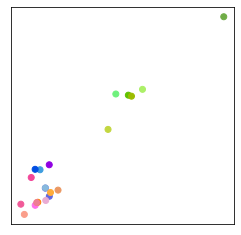

In [138]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.scatter(a, b, c=ordered_colors)
ax.set_yticks([])
ax.set_xticks([])
plt.savefig('../../figures/corrected_gls_expression.pdf', dpi=400, bbox_inches='tight')

In [45]:
spearmanr(c, b)

SpearmanrResult(correlation=0.5116883116883117, pvalue=0.017736397243725104)

In [47]:
np.zeros(21) + 1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [48]:
d = (np.zeros(21) + 1).dot(precision)